In [129]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [130]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

38518
19
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [131]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: '&', 2: '(', 3: ')', 4: ',', 5: '/', 6: '0', 7: '8', 8: '[', 9: 'a', 10: 'b', 11: 'c', 12: 'd', 13: 'e', 14: 'f', 15: 'g', 16: 'h', 17: 'i', 18: 'j', 19: 'k', 20: 'l', 21: 'm', 22: 'n', 23: 'o', 24: 'p', 25: 'q', 26: 'r', 27: 's', 28: 't', 29: 'u', 30: 'v', 31: 'w', 32: 'x', 33: 'y', 34: 'z', 0: '.'}
35


In [132]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [133]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([220674, 8]) torch.Size([220674])
torch.Size([27584, 8]) torch.Size([27584])
torch.Size([27602, 8]) torch.Size([27602])


In [134]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> k
.......k --> i
......ki --> o
.....kio --> n
....kion --> n
...kionn --> a
..kionna --> .
........ --> a
.......a --> l
......al --> m
.....alm --> i
....almi --> n
...almin --> .
........ --> k
.......k --> r
......kr --> i
.....kri --> s
....kris --> h
...krish --> a
..krisha --> n


In [135]:
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1) 
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else: #during inference, use the running mean and variance
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
  
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [136]:
torch.manual_seed(42)

In [137]:
n_embd = 24 #the dimensionality of the character embeddings vector
n_hidden = 128 #the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    #last layer: make less confident
    model.layers[-1].weight *= 0.01

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


77803


In [138]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.5549
  10000/ 200000: 1.8245
  20000/ 200000: 2.0165
  30000/ 200000: 2.0281
  40000/ 200000: 2.0155
  50000/ 200000: 1.8193
  60000/ 200000: 1.8390
  70000/ 200000: 1.8365
  80000/ 200000: 1.9063
  90000/ 200000: 2.1870
 100000/ 200000: 2.1973
 110000/ 200000: 2.0044
 120000/ 200000: 1.6338
 130000/ 200000: 2.2165
 140000/ 200000: 1.9600
 150000/ 200000: 1.9003
 160000/ 200000: 2.1484
 170000/ 200000: 1.6396
 180000/ 200000: 2.1503
 190000/ 200000: 1.5651


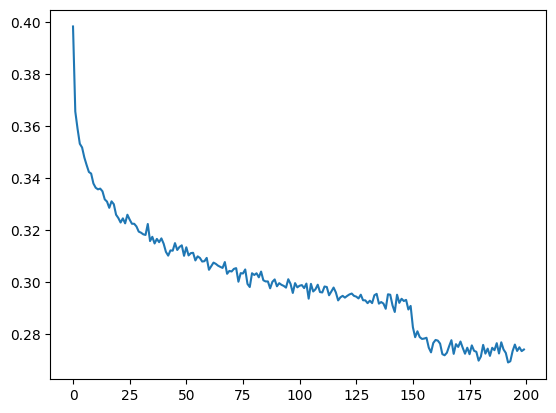

In [143]:
#instead of plotting the loss for each batch, we plot the average loss over 1000 batches
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [144]:
#put layers in eval mode
for layer in model.layers:
    layer.training = False

In [145]:
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8544987440109253
val 2.0299203395843506


### performance log

train - 1.9101
val - 2.0193

train 1.7697079181671143
val 1.9891843795776367

In [149]:
for _ in range(20):
	
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
  	    # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print((''.join(itos[i] for i in out))[:-1]) # decode and print the generated word

torles
giba
shreen
decklan
kaeson
ashbu
raylen
rimsel
niko
remy
kaislay
jidee
raybella
aivon
jenedir
criston
jareem
washay
niroa
shubhba
